# Imágenes tomadas con una cámara

Una vez comprobado que el programa detecta bien los defectos de nuestras imágenes de prueba, lo comprobamos con frutas a las que les hemos tomado una fotografía para comprobar que no funciona solo con imágenes en un entorno perfecto, y se podría hacer en cualquier lugar.

Este cuaderno es implementar el mismo código que nos encontramos en la Parte-2, pero con otra imagen, por lo que no variará la explicación de cada apartado.

En primer lugar cargamos la imagen para ver al inicio como es, así como realizar un preprocesamiento de la imagen, donde aplicamos un suavizado por mediana, para eliminar todo tipo de ruido que pueda haber, manteniendo los bordes intactos para poder analizarlos bien más adelante

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función para mostrar imágenes
def show(img, title="", cmap=None):
    plt.figure(figsize=(6,6))
    if cmap is None:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Cargar imagen
path = './images/'
img = cv2.imread(path + 'Platano1.jpg')
original = img.copy()


# Comprobamos si la imagen se cargó correctamente
if img is None:
    print("Error: No se pudo cargar la imagen. Revisa la ruta.")
else:
    show(original, "Imagen Original")


# Suavizado para eliminar ruido
blurred = cv2.medianBlur(img, 5)

Deberemos de aplicar un histograma para detectar las zonas más oscuras de la imagen. En lugar de considerar oscuro todo lo que esté por debajo de un valor fijo, usaremos el algoritmo de Otsu. Este analiza el histograma de luz de la foto y nos calcula matemáticamente el punto exacto que nos separa la piel clara de las manchas más oscuras.

Esto nos generará una máscara en blanco y negro, donde lo blanco son los posibles defectos oscuros.

In [ ]:
# Detección de zonas oscuras (Histograma)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([gray], [0], None, [256], [0,256])

# Buscamos el pico de oscuridad en los primeros 100 valores y sumamos un margen
shadow_thresh = np.argmax(hist[:100]) + 5
_, shadow_mask = cv2.threshold(gray, shadow_thresh, 255, cv2.THRESH_BINARY)

# Limpiamos ruido en la máscara y la invertimos para que lo blanco sea lo oscuro
shadow_mask = cv2.medianBlur(shadow_mask, 9)
shadow_mask = cv2.bitwise_not(shadow_mask)

show(shadow_mask, "Máscara de Zonas Oscuras", cmap='gray')

En la imagen podemos ver que detecta de forma bastante buena el área de la imagen que se encuentra defectuosa.

Una vez obtenido el histograma, buscaremos si puede llegar a haber algún falso positivo, ya que el paso anterior nos puede detectar zonas que no son defectuosas, como el tallo de la manzana o una sombra algo pequeña.

Para comprobar que todo ha salido bien, el código buscará el defecto de dos formas a la vez: 

- Por el color, que busca los píxeles que tengan un color algo raro.

In [ ]:
# Detección por rango de color (HSV)
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

lower_defect = np.array([0, 30, 0])
upper_defect = np.array([180, 255, 120])

color_mask = cv2.inRange(hsv, lower_defect, upper_defect)

show(color_mask, "Candidatos por Color/Brillo", cmap='gray')

- Por bordes, usando el algoritmo de Canny, que busca los cambios bruscos en la superficie.

In [ ]:
# Detección de bordes
edges = cv2.Canny(gray, 40, 120)

# Hacemos grandes los bordes para conectarlos mejor
edges = cv2.dilate(edges, np.ones((5,5), np.uint8), iterations=2)

show(edges, "Bordes Detectados", cmap='gray')

Finalmente, nuestro código tomará todas los pasos que hemos realizado previamente para dibujar el contorno final.

Se marcará el área de defecto si cumple ambas condiciones:
- Tiene un borde extraño o tiene un color extraño.
- Está dentro de la zona oscura detectada por el algoritmo de Otsu.

Esto nos detectará si hay una sombra pero no tiene bordes de textura, el código la ignorará, y si tien bordes pero no es oscura, el código la ignorará.

In [ ]:
# Solo aceptamos bordes que caigan dentro de la zona oscura
defect_edges = cv2.bitwise_and(edges, edges, mask=shadow_mask)

# Solo aceptamos defectos de color que caigan dentro de la zona oscura
defect_color = cv2.bitwise_and(color_mask, color_mask, mask=shadow_mask)

# Combinación
combined = cv2.bitwise_or(defect_edges, defect_color)

# Si la combinación borra todo, volvemos al color)
if np.sum(combined) < 20:
    print("Aviso: Detección combinada muy baja, usando solo color.")
    combined = defect_color

# Limpieza final de la máscara combinada
combined = cv2.medianBlur(combined, 7)
show(combined, "Máscara Combinada FINAL", cmap='gray')

In [ ]:
# Mostramos resultado final con contornos
resultado = original.copy()
contornos, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujamos en azul los contornos detectados
cv2.drawContours(resultado, contornos, -1, (255, 0, 0), thickness=3)

show(resultado, "Resultado Final")

A continuación, implementaremos otra imagen para comprobar que funciona sin ningún fallo. Mostraremos solo la imagen original y la imagen con la zona marcada para evitar revisar todas las máscaras.

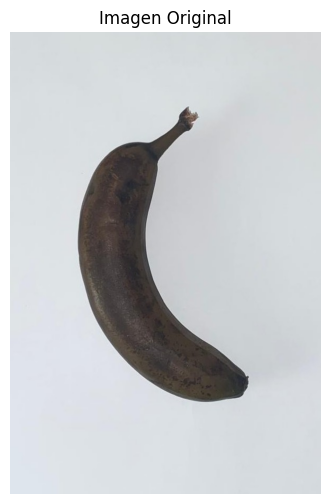

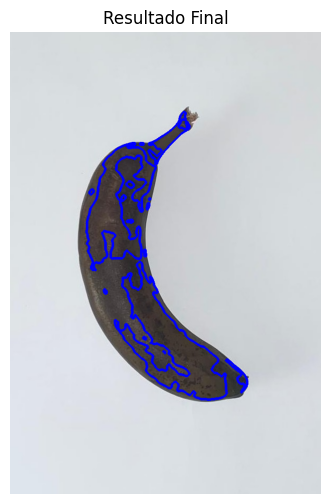

In [8]:
# Cargar imagen
path = './images/'
img = cv2.imread(path + 'Platano2.jpg')
original = img.copy()


# Comprobamos si la imagen se cargó correctamente
if img is None:
    print("Error: No se pudo cargar la imagen. Revisa la ruta.")
else:
    show(original, "Imagen Original")


# Suavizado para eliminar ruido
blurred = cv2.medianBlur(img, 5)


# Detección de zonas oscuras (Histograma)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([gray], [0], None, [256], [0,256])

# Buscamos el pico de oscuridad en los primeros 100 valores y sumamos un margen
shadow_thresh = np.argmax(hist[:100]) + 5
_, shadow_mask = cv2.threshold(gray, shadow_thresh, 255, cv2.THRESH_BINARY)

# Limpiamos ruido en la máscara y la invertimos para que lo blanco sea lo oscuro
shadow_mask = cv2.medianBlur(shadow_mask, 9)
shadow_mask = cv2.bitwise_not(shadow_mask)


# Detección por rango de color (HSV)
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

lower_defect = np.array([0, 30, 0])
upper_defect = np.array([180, 255, 120])

color_mask = cv2.inRange(hsv, lower_defect, upper_defect)


# Detección de bordes
edges = cv2.Canny(gray, 40, 120)

# Hacemos grandes los bordes para conectarlos mejor
edges = cv2.dilate(edges, np.ones((5,5), np.uint8), iterations=2)


# Solo aceptamos bordes que caigan dentro de la zona oscura
defect_edges = cv2.bitwise_and(edges, edges, mask=shadow_mask)

# Solo aceptamos defectos de color que caigan dentro de la zona oscura
defect_color = cv2.bitwise_and(color_mask, color_mask, mask=shadow_mask)

# Combinación
combined = cv2.bitwise_or(defect_edges, defect_color)

# Si la combinación borra todo, volvemos al color)
if np.sum(combined) < 20:
    print("Aviso: Detección combinada muy baja, usando solo color.")
    combined = defect_color

# Limpieza final de la máscara combinada
combined = cv2.medianBlur(combined, 7)

# Mostramos resultado final con contornos
resultado = original.copy()
contornos, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujamos en azul los contornos detectados
cv2.drawContours(resultado, contornos, -1, (255, 0, 0), thickness=3)

show(resultado, "Resultado Final")